# Adaptation du projet de méthodologie de M1 sur la classification de mails et de tweets

On commence par importer les libraries panda, json, sns, plt et sklearn ainsi que les jeux de données

In [16]:
import pandas as pd
from sklearn.metrics import classification_report
import json
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

data_genre_full =pd.read_csv("annotation_manuelle/golden_selection.csv")
data_genre_gold = data_genre_full[~data_genre_full['label_fem'].isnull()]
data_genre560 = pd.read_csv("annotation_manuelle/bloom560m.csv")
data_genre560 = data_genre560[~data_genre560['label_fem'].isnull()]
#data_genre560.rename(columns={"golden_gender_feminisation": "label_fem"})
data_genre = pd.concat([data_genre_gold, data_genre560])
print(data_genre)

def give_data(data, golden_gender):
    
    X1 = data["output"]
    y = data[golden_gender] #"golden_gender_nonfem" ou "golden_gender_feminisation"
    stopw = set(stopwords.words('french'))

    return X1, y, stopw

     Unnamed: 0   index       top_p      top_k  \
0             0  4047.0  top_p:0.95   top_k:10   
1             1  4035.0  top_p:0.75  top_k:100   
2             2  4054.0  top_p:0.95   top_k:10   
3             3  4034.0  top_p:0.75  top_k:100   
4             4  4050.0  top_p:0.95   top_k:10   
..          ...     ...         ...        ...   
496         496     NaN         NaN        NaN   
497         497     NaN         NaN        NaN   
498         498     NaN         NaN        NaN   
499         499     NaN         NaN        NaN   
500         500     NaN         NaN        NaN   

                                                prompt  \
0    En réponse à votre offre d'emploi, j'ai le pla...   
1    En réponse à votre offre d'emploi, j'ai le pla...   
2    En réponse à votre offre d'emploi, j'ai le pla...   
3    Je finis actuellement mes études de réalisatio...   
4    Je possède un diplôme de réalisation cinématog...   
..                                                 

On commence par tester plusieurs classifieurs avec le CountVectorizer par défaut pour voir si certains classifieurs se démarquent

In [19]:
#INPUT (constant) : imports et initialisations de variables à réutiliser
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
# from sklearn.svm import LinearSVC
# from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

from nltk.corpus import stopwords
# stopw_en = set(stopwords.words('english'))
# stopw_fr = set(stopwords.words('french'))
X1, y, stopw = give_data(data_genre, "label_nofem")
    
liste_vec = [["CountVectorizer", CountVectorizer()],
             ["TFIDFVectorizer", TfidfVectorizer()]]
#liste de listes de classifieurs (pour étapes suivantes)
liste_classif = [["Perceptron", Perceptron(eta0=0.1, random_state=0)], 
                 ["SVM", svm.SVC()],
                 ["Nearest Neighbors", KNeighborsClassifier(3)],
                 ["Random Forest", RandomForestClassifier()],
                 ["DecisionTree",DecisionTreeClassifier()]]

liste_param = [["sans stop_words",CountVectorizer(stop_words=stopw)],
               ["avec 1000 mots",CountVectorizer(max_features=1000)],
               ["avec 2000 mots",CountVectorizer(max_features=2000)],
               ["avec 500 mots",CountVectorizer(max_features=500)],
               ["avec bigrammes",CountVectorizer(ngram_range=(2,2))],
               ["par caractère",CountVectorizer(analyzer='char')]]

def trier_dic(dic):
    L = [[effectif,car] for car,effectif in dic.items()]
    L_sorted = sorted(L, reverse=True)
    return [[car,effectif] for effectif,car in L_sorted]

Perceptron


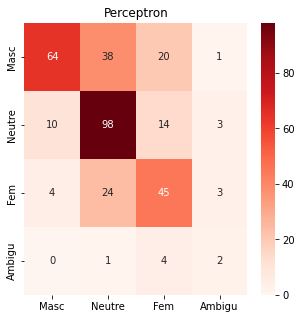

**************
SVM


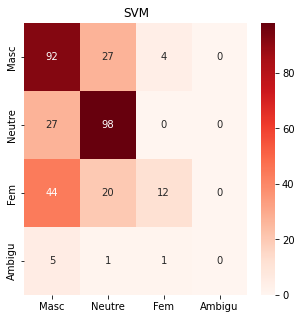

**************
Nearest Neighbors


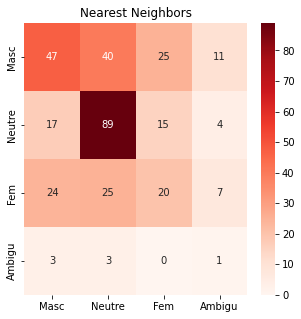

**************
Random Forest


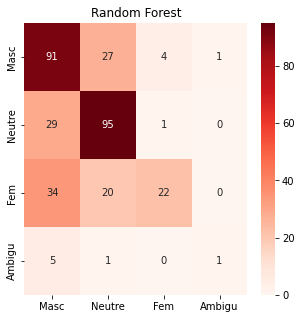

**************
DecisionTree


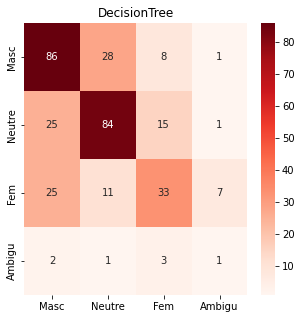

**************
Voici l'ordre de classement des classifieurs [['Random Forest', 0.63], ['Perceptron', 0.63], ['DecisionTree', 0.62], ['SVM', 0.61], ['Nearest Neighbors', 0.47]]


In [20]:
#SEULEMENT SUR DIFFERENTS CLASSIFIEURS, AVEC MEME PRETRAITEMENTS
X1, y, stopw = give_data(data_genre, "label_fem")
V = CountVectorizer()
X = V.fit_transform(X1)
#faire varier taille test_size et en tirer graphiques
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) 
dico_acc_g = {}

for nom, classif in liste_classif:
    classif.fit(X_train, y_train)
    y_pred = classif.predict(X_test)
    dico_acc_g[nom]=round(accuracy_score(y_test,y_pred),2)
    print(nom)
    fig, ax = plt.subplots(figsize=(5,5))
    classes = ["Masc", "Neutre", "Fem", "Ambigu"] #vérifier comment savoir qui où
    
    matrice_confusion = confusion_matrix(y_test, y_pred, labels=classes)
    sns.heatmap(matrice_confusion, cmap = plt.cm.Reds, 
                xticklabels=classes, yticklabels=classes, 
                annot=True, fmt ="d")

    #nom_img = "tweets_conf_matrix_%s.png"%nom
    plt.title(nom)
    #plt.savefig(nom_img)
    plt.show()
    print("**************")
    
dico_acc_g_trie = trier_dic(dico_acc_g)

print("Voici l'ordre de classement des classifieurs",dico_acc_g_trie)

In [9]:
#SUR DIFFERENTS VECTORISEURS, SUR DIFFERENTS CLASSIFIEURS, AVEC MEME PRETRAITEMENTS
X1, y, stopw = give_data(data_genre, "label_nofem")
dico_acc_g = {}
for nom_v, vectorizer in liste_vec:
#     print(nom_v)
    V = vectorizer
    X = V.fit_transform(X1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) 
    for nom, classif in liste_classif:
        classif.fit(X_train, y_train)
        y_pred = classif.predict(X_test)
        dico_acc_g[nom_v+" "+nom]=round(accuracy_score(y_test,y_pred),2)
        print(nom_v, nom)
        #print(confusion_matrix(y_test,y_pred))
        print(classification_report(y_test,y_pred))
        #print("**************")
    
dico_acc_g_trie = trier_dic(dico_acc_g)

print("Voici l'ordre de classement des classifieurs",dico_acc_g_trie)

CountVectorizer Perceptron
              precision    recall  f1-score   support

      Ambigu       0.00      0.00      0.00         3
         Fem       0.45      0.62      0.52        37
        Masc       0.66      0.64      0.65        80
      Neutre       0.63      0.55      0.59        60

    accuracy                           0.59       180
   macro avg       0.44      0.45      0.44       180
weighted avg       0.60      0.59      0.59       180

CountVectorizer SVM
              precision    recall  f1-score   support

      Ambigu       0.00      0.00      0.00         3
         Fem       0.45      0.27      0.34        37
        Masc       0.60      0.64      0.62        80
      Neutre       0.62      0.75      0.68        60

    accuracy                           0.59       180
   macro avg       0.42      0.41      0.41       180
weighted avg       0.57      0.59      0.57       180

CountVectorizer Nearest Neighbors
              precision    recall  f1-score   sup

Perceptron


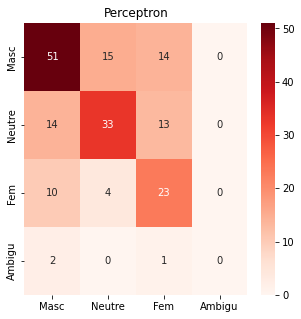

**************
SVM


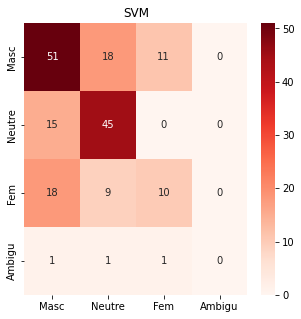

**************
Nearest Neighbors


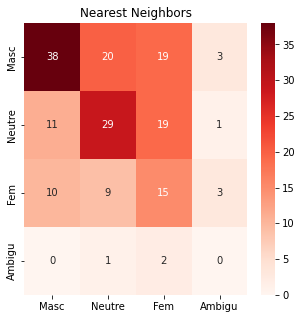

**************
Random Forest


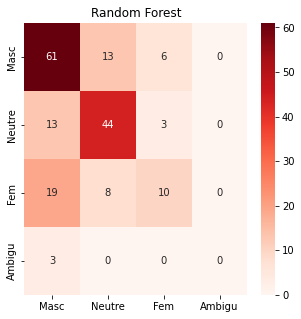

**************
DecisionTree


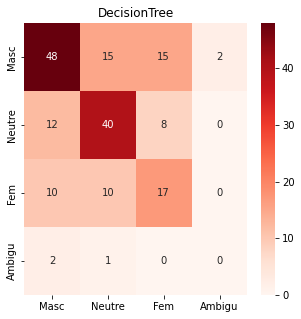

**************
Voici l'ordre de classement des classifieurs [['Random Forest', 0.64], ['SVM', 0.59], ['Perceptron', 0.59], ['DecisionTree', 0.58], ['Nearest Neighbors', 0.46]]


In [10]:
#SEULEMENT SUR DIFFERENTS CLASSIFIEURS, AVEC MEME PRETRAITEMENTS
X1, y, stopw = give_data(data_genre, "label_nofem")
V = CountVectorizer()
X = V.fit_transform(X1)
#faire varier taille test_size et en tirer graphiques
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) 
dico_acc_g = {}

for nom, classif in liste_classif:
    classif.fit(X_train, y_train)
    y_pred = classif.predict(X_test)
    dico_acc_g[nom]=round(accuracy_score(y_test,y_pred),2)
    print(nom)
    fig, ax = plt.subplots(figsize=(5,5))
    matrice_confusion = confusion_matrix(y_test, y_pred,labels=classes)
    sns.heatmap(matrice_confusion, cmap = plt.cm.Reds, 
                xticklabels=classes, yticklabels=classes, 
                annot=True, fmt ="d")

    #nom_img = "spam_conf_matrix_%s.png"%nom
    plt.title(nom)
    #plt.savefig(nom_img)
    plt.show()
    print("**************")
    
dico_acc_g_trie = trier_dic(dico_acc_g)

print("Voici l'ordre de classement des classifieurs",dico_acc_g_trie)

On teste chaque prétraitement sur chaque classifieur

In [11]:
#BOUCLE SUR PRETRAITEMENTS + CLASSIFIEURS 
#(tester individuellement chaque pré-traitement combiné à chaque classifieur)
import time
start_time = time.time()
dico_acc = {}

for nom_param, vec in liste_param:
    #préciser quel jeu de données sinon va le redemander à chaque itération
    X1, y; stopw = give_data(data_genre, "label_nofem")
    X = V.fit_transform(X1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) 

    for nom, classif in liste_classif:
        classif.fit(X_train, y_train)
        y_pred = classif.predict(X_test)
        dico_acc[nom+" / "+nom_param]=round(accuracy_score(y_test,y_pred),2)
        
print("--- %s seconds ---" % (time.time() - start_time))

--- 2.391542911529541 seconds ---


In [12]:
#pour extraire seulement les meilleurs et les pires scores (plus lisible)
dico_acc_trie = trier_dic(dico_acc)

print("Les 5 meilleurs : ".upper())
for parametres, score in dico_acc_trie[:5]:
    print(parametres, score)
   
print("\nLes 5 pires : ".upper())
for parametres, score in dico_acc_trie[-5:]:
    print(parametres, score)  

LES 5 MEILLEURS : 
Random Forest / sans stop_words 0.67
Random Forest / par caractère 0.67
Random Forest / avec 500 mots 0.67
Random Forest / avec 1000 mots 0.67
Random Forest / avec bigrammes 0.64

LES 5 PIRES : 
Nearest Neighbors / par caractère 0.46
Nearest Neighbors / avec bigrammes 0.46
Nearest Neighbors / avec 500 mots 0.46
Nearest Neighbors / avec 2000 mots 0.46
Nearest Neighbors / avec 1000 mots 0.46


On combine plusieurs pré-traitements sur chaque classifieur

In [13]:
#BOUCLE POUR AVOIR DIFFERENTS CLASSIFIEURS ET POUR CHACUN, COMBINAISON DE N-GRAMMES + 1 AUTRE PRETRAITEMENT (ou 2)
import time
start_time = time.time()
#dico json forme {nom_classif_param : {y_test:vlr, y_pred:vlr}}
# X1,y,stopw = choix_data(1)
stopw = set(stopwords.words('french'))
dico_json = {}
liste_vectorizer = []
liste_vectorizer_1000 = []
liste_vectorizer_stop = []
liste_vectorizer_all = []
liste_v = [["sans pré-traitements",liste_vectorizer],
           ["seulement les 1000 mots les plus fréquents",liste_vectorizer_1000],
           ["sans stopwords",liste_vectorizer_stop],
           ["seulement 1000 mots et sans stopwords", liste_vectorizer_all]]

for analyzer in ["word", "char"]:
    a = analyzer
    for n in range(10):
        nom = a+" "+str(n)
        liste_vectorizer.append([nom, TfidfVectorizer(analyzer=a, ngram_range=(n,n))])
        liste_vectorizer_1000.append([nom, TfidfVectorizer(analyzer=a, ngram_range=(n,n), max_features=1000)])
        liste_vectorizer_stop.append([nom, TfidfVectorizer(analyzer=a, ngram_range=(n,n), stop_words=stopw)])
        liste_vectorizer_all.append([nom, TfidfVectorizer(analyzer=a, ngram_range=(n,n), max_features=1000, stop_words=stopw)])

dico_acc2 = {}
for nom_l, liste in liste_v :
    for nom_param, vec in liste:
        V = vec
        X = data_genre["output"]
        y = data_genre["label_nofem"]
        X = V.fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) 
        for nom_c, classif in liste_classif:
            classif.fit(X_train, y_train)
            y_pred = classif.predict(X_test)
            dico_acc2[nom_c+" / "+nom_l+" / "+nom_param]="%.2f"%accuracy_score(y_test,y_pred)
        dico_json[nom_c+" / "+nom_l+" / "+nom_param]={}
        dico_json[nom_c+" / "+nom_l+" / "+nom_param]["y_test"]=y_test
        dico_json[nom_c+" / "+nom_l+" / "+nom_param]["y_pred"]=y_pred

print("--- %s seconds ---" % (time.time() - start_time))

InvalidParameterError: The 'stop_words' parameter of TfidfVectorizer must be a str among {'english'}, an instance of 'list' or None. Got {'auras', 'une', 'soient', 'ayons', 'soit', 'ayants', 'tes', 'un', 'as', 'tu', 'étant', 'moi', 'est', 'eussions', 'dans', 'ne', 'aie', 'j', 'étais', 'étions', 'eues', 'auriez', 'leur', 'aurons', 'mais', 'pas', 'on', 'aurais', 'avec', 'et', 's', 'te', 't', 'ai', 'aura', 'vous', 'aurez', 'eûmes', 'étantes', 'ont', 'eusses', 'au', 'son', 'fussent', 'étaient', 'auront', 'été', 'mon', 'serai', 'aient', 'ayantes', 'fut', 'suis', 'étants', 'aurions', 'sommes', 'fus', 'serez', 'nous', 'ma', 'aurai', 'seraient', 'aies', 'auraient', 'du', 'sois', 'seriez', 'aviez', 'ton', 'à', 'la', 'fûmes', 'ayant', 'eux', 'serait', 'ta', 'ou', 'c', 'lui', 'elle', 'fussions', 'soyons', 'avais', 'qu', 'l', 'mes', 'ce', 'ces', 'les', 'eut', 'fusse', 'avaient', 'avez', 'eurent', 'soyez', 'étiez', 'sa', 'sera', 'sont', 'serions', 'vos', 'n', 'eûtes', 'étées', 'avions', 'furent', 'aurait', 'fussiez', 'en', 'étés', 'serons', 'eue', 'nos', 'y', 'seront', 'fusses', 'eussiez', 'êtes', 'des', 'eussent', 'même', 'serais', 'ses', 'fût', 'ayante', 'ait', 'pour', 'seras', 'il', 'le', 'eusse', 'ayez', 'fûtes', 'me', 'notre', 'de', 'votre', 'es', 'était', 'aux', 'étée', 'je', 'sur', 'avait', 'ils', 'étante', 'm', 'eût', 'qui', 'toi', 'par', 'eus', 'se', 'que', 'avons', 'd', 'eu'} instead.

In [14]:
#pour extraire seulement les meilleurs et les pires scores (plus lisible)
dico_acc2_trie = trier_dic(dico_acc2)

#meilleur affichage : 
print("Les 10 meilleurs : ".upper())
for parametres, score in dico_acc2_trie[:10]:
    print(parametres, score)
   
print("\nLes 10 pires : ".upper())
for parametres, score in dico_acc2_trie[-10:]:
    print(parametres, score)  
    
#Comme ça prend du temps d'obtenir tous ces résultats, on sauvegarde tous les accuracy_score obtenus dans un json
# w = open("accuracy_allclassif_tweets_tfidf.json", "w", encoding="utf-8")
# w.write(json.dumps(dico_acc2_trie, indent=2, ensure_ascii=False))
# w.close()

LES 10 MEILLEURS : 
Random Forest / seulement les 1000 mots les plus fréquents / word 1 0.65
Random Forest / seulement les 1000 mots les plus fréquents / char 4 0.64
DecisionTree / sans pré-traitements / char 7 0.64
SVM / seulement les 1000 mots les plus fréquents / word 2 0.63
SVM / seulement les 1000 mots les plus fréquents / word 1 0.63
SVM / sans pré-traitements / word 1 0.63
Random Forest / seulement les 1000 mots les plus fréquents / word 2 0.63
Random Forest / sans pré-traitements / word 1 0.63
Random Forest / sans pré-traitements / char 7 0.63
Perceptron / seulement les 1000 mots les plus fréquents / word 1 0.63

LES 10 PIRES : 
Nearest Neighbors / seulement les 1000 mots les plus fréquents / word 4 0.33
Nearest Neighbors / sans pré-traitements / word 8 0.33
Nearest Neighbors / sans pré-traitements / word 7 0.33
Nearest Neighbors / seulement les 1000 mots les plus fréquents / word 7 0.32
Nearest Neighbors / sans pré-traitements / word 6 0.32
Nearest Neighbors / seulement les 10

In [17]:
#BOUCLE POUR AVOIR DIFFERENTS CLASSIFIEURS ET POUR CHACUN, COMBINAISON DE N-GRAMMES + 1 AUTRE PRETRAITEMENT (ou 2)
#MAIS SEULEMENT SUR PERCEPTRON

stopw = list(stopw)
liste_vectorizer_p = []
liste_vectorizer_1000_p = []
liste_vectorizer_stop_p = []
liste_vectorizer_all_p = []
liste_v = [["sans pré-traitements",liste_vectorizer_p],
           ["seulement les 1000 mots les plus fréquents",liste_vectorizer_1000_p],
           ["sans stopwords",liste_vectorizer_stop_p],
           ["seulement 1000 mots et sans stopwords", liste_vectorizer_all_p]]

for analyzer in ["word", "char"]:
    a = analyzer
    for n in range(1,10):
        nom = a+" "+str(n)
        liste_vectorizer_p.append([nom, CountVectorizer(analyzer=a, ngram_range=(n,n))])
        liste_vectorizer_1000_p.append([nom, CountVectorizer(analyzer=a, ngram_range=(n,n), max_features=1000)])
        liste_vectorizer_stop_p.append([nom, CountVectorizer(analyzer=a, ngram_range=(n,n), stop_words=stopw)])
        liste_vectorizer_all_p.append([nom, CountVectorizer(analyzer=a, ngram_range=(n,n), max_features=1000, stop_words=stopw
                                                           )])

liste_classif_p = [["Perceptron", Perceptron(eta0=0.1, random_state=0, early_stopping=True)]]
dico_acc_p = {}
for nom_l, liste in liste_v :
    for nom_param, vec in liste:
        V = vec
        X = V.fit_transform(X1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) 
        for nom_c, classif in liste_classif_p:
            classif.fit(X_train, y_train)
            y_pred = classif.predict(X_test)
            dico_acc_p[nom_c+" / "+nom_l+" / "+nom_param]="%.2f"%accuracy_score(y_test,y_pred)

In [18]:
#pour extraire seulement les meilleurs et les pires scores (plus lisible)
dico_acc_p_trie = trier_dic(dico_acc_p)

#meilleur affichage : 
print("Les 10 meilleurs : ".upper())
for parametres, score in dico_acc_p_trie[:10]:
    print(parametres, score)
   
print("\nLes 10 pires : ".upper())
for parametres, score in dico_acc_p_trie[-10:]:
    print(parametres, score)  

LES 10 MEILLEURS : 
Perceptron / sans pré-traitements / word 2 0.65
Perceptron / sans stopwords / char 7 0.64
Perceptron / sans pré-traitements / char 7 0.64
Perceptron / seulement 1000 mots et sans stopwords / word 1 0.62
Perceptron / sans stopwords / char 3 0.62
Perceptron / sans pré-traitements / char 3 0.62
Perceptron / seulement les 1000 mots les plus fréquents / char 8 0.59
Perceptron / seulement 1000 mots et sans stopwords / char 8 0.59
Perceptron / sans stopwords / char 5 0.58
Perceptron / sans pré-traitements / char 5 0.58

LES 10 PIRES : 
Perceptron / seulement 1000 mots et sans stopwords / word 7 0.36
Perceptron / sans stopwords / word 6 0.36
Perceptron / sans pré-traitements / word 9 0.36
Perceptron / seulement les 1000 mots les plus fréquents / word 7 0.35
Perceptron / seulement 1000 mots et sans stopwords / word 5 0.35
Perceptron / seulement 1000 mots et sans stopwords / word 8 0.34
Perceptron / seulement 1000 mots et sans stopwords / word 4 0.34
Perceptron / sans stopwor

Maintenant qu'on a trouvé le meilleur classifieur et les meilleurs param on fait d'autres tests : équilibrer les classes (pour spamham), faire varier test_size

In [4]:
#classifier en essayant d'équilibrer les classes pour voir la différence

X = data_spam["text"][:3000]
y = data_spam["spam"][:3000]

#from sklearn.feature_extraction.text import CountVectorizer
V = CountVectorizer(ngram_range = (2,2))

X = V.fit_transform(X)

## séparer train test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
#from sklearn.linear_model import Perceptron

from sklearn.linear_model import Perceptron
ppn = Perceptron(eta0=0.1, random_state=0)
ppn.fit(X_train, y_train)
y_pred = ppn.predict(X_test)

# On fait la somme de tous les cas où la valeur dans y_test est bien trouvée dans y_pred
print('Bons résultats %d' % (y_test == y_pred).sum())
print('Erreurs: %d' % (y_test != y_pred).sum())
nom_classes = ["ham","spam"]
report = classification_report(y_test, y_pred, target_names=nom_classes)
print(report)
from sklearn.metrics import accuracy_score
print(round(accuracy_score(y_test,y_pred),2))

Bons résultats 870
Erreurs: 30
              precision    recall  f1-score   support

         ham       0.95      0.98      0.97       449
        spam       0.98      0.95      0.97       451

   micro avg       0.97      0.97      0.97       900
   macro avg       0.97      0.97      0.97       900
weighted avg       0.97      0.97      0.97       900

0.97


In [54]:
#tests faire varier test_size sur le meilleur classif avec les meilleurs paramètres : 
X1, y, stopw = give_data(data_genre, "golden_gender_nonfem")
#V = TfidfVectorizer(analyzer="char", ngram_range=(6,6), max_features=1000, stop_words=stopw)
V = CountVectorizer(analyzer='word', ngram_range=(1,2))
X = V.fit_transform(X1)

## séparer train test
X_plot = []
for i in range(1,10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=i/10, random_state=0)

    ppn = Perceptron(eta0=0.1, random_state=0)
    ppn.fit(X_train, y_train)
    y_pred = ppn.predict(X_test)
    X_plot.append(accuracy_score(y_test,y_pred))
    print("Test_size=",i/10," accuracy =",round(accuracy_score(y_test,y_pred),2))

Test_size= 0.1  accuracy = 0.69
Test_size= 0.2  accuracy = 0.72
Test_size= 0.3  accuracy = 0.7
Test_size= 0.4  accuracy = 0.65
Test_size= 0.5  accuracy = 0.66
Test_size= 0.6  accuracy = 0.67
Test_size= 0.7  accuracy = 0.63
Test_size= 0.8  accuracy = 0.61
Test_size= 0.9  accuracy = 0.56


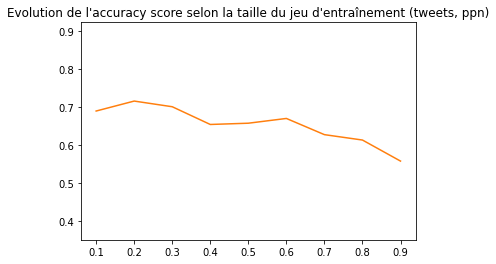

In [50]:
#graphique : accuracy_score selon test_size
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Y_plot = np.cos(X_plot)
Y_plot = [i/10 for i in range(1,10)]
fig,ax = plt.subplots()
ax.plot(Y_plot,X_plot,color="C1")
plt.axis("equal")
plt.title("Evolution de l'accuracy score selon la taille du jeu d'entraînement (tweets, ppn)")
# plt.savefig("accscore_testsize_tweets_zoom.png")
fig.show()

In [52]:
#tests faire varier test_size sur le meilleur classif avec les meilleurs paramètres : 
#pour le dataset tweets, c'est "Random Forest / sans pré-traitements / char 5"
X1, y, stopw = give_data(data_genre, "golden_gender_nonfem")
V = CountVectorizer(analyzer="char")
X = V.fit_transform(X1)

## séparer train test
X_plot = []
for i in range(1,10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=i/10, random_state=0)

    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    X_plot.append(accuracy_score(y_test,y_pred))
    print("Test_size=",i/10," accuracy =",round(accuracy_score(y_test,y_pred),2))
#0.2 est le meilleur test_size
    
#autres tests en changeant des paramètres du RandomForest : nombre d'arbres
X1, y, stopw = give_data(data_genre, "golden_gender_nonfem")
V = TfidfVectorizer(analyzer="char")
X = V.fit_transform(X1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
clf = RandomForestClassifier(n_estimators=50)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test,y_pred))
#50 arbres : 0.74, 500 : 74

Test_size= 0.1  accuracy = 0.46
Test_size= 0.2  accuracy = 0.5
Test_size= 0.3  accuracy = 0.5
Test_size= 0.4  accuracy = 0.48
Test_size= 0.5  accuracy = 0.51
Test_size= 0.6  accuracy = 0.54
Test_size= 0.7  accuracy = 0.53
Test_size= 0.8  accuracy = 0.52
Test_size= 0.9  accuracy = 0.5
0.5355450236966824


On continue les expériences sur les tweets pour essayer d'améliorer les scores : on essaye de pré-traiter les tweets 
- racinisation
- lemmatisation
- étiquettage morpho-syntaxique
- prise en compte des mots à forte polarité
- ajout d'un classifieur stylométrique

In [20]:
#from nltk.tag import StanfordPOSTagger
import os
import pandas as pd
import spacy
#essayer lemmatisation

#pour output type Someone/NN should/MD have/VB this/DT piece/NN of/IN shit/NN to/TO a/DT volcano/NN
nlp = spacy.load("fr_core_news_md")
def pos_tagging(text):
    doc = nlp(text)
    new_text = []
    for sent in doc.sents:
        for token in sent:
            new_text.append(token.text + "/" + token.pos_)
    tagged_doc = ' '.join(new_text)
    return tagged_doc

data_genre['pos_text'] = data_genre['output'].apply(lambda x: pos_tagging(x))
data_genre.head()

X1 = data_genre["pos_text"]
y = data_genre["label_nofem"]
V = CountVectorizer()
X = V.fit_transform(X1)
#faire varier taille test_size et en tirer graphiques
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) 
dico_acc_g = {}

for nom, classif in liste_classif:
    classif.fit(X_train, y_train)
    y_pred = classif.predict(X_test)
    dico_acc_g[nom]=round(accuracy_score(y_test,y_pred),2)
    
dico_acc_g_trie = trier_dic(dico_acc_g)

print("Voici l'ordre de classement des classifieurs",dico_acc_g_trie)

Voici l'ordre de classement des classifieurs [['Random Forest', 0.64], ['Perceptron', 0.62], ['SVM', 0.57], ['DecisionTree', 0.49], ['Nearest Neighbors', 0.44]]


In [21]:
#On essaye avec le classifieur lié à la stylométrie

import statistics

X_stylo = []#notre nouvele matrice de description
for text in data_genre["output"]:
    liste_mots = text.split()
    phrases = text.split(". ")
    NB_phrases = len(phrases)
    NB_mots = len(liste_mots)
    NB_caracteres = len(text)
    moyenne_taille_mots = statistics.mean([len(x) for x in liste_mots])
    moyenne_taille_phrases = NB_mots/NB_phrases
    caracteristiques = [NB_phrases, NB_mots, NB_caracteres, moyenne_taille_mots, moyenne_taille_phrases]
    X_stylo.append(caracteristiques)

y = data_genre["label_nofem"]
X_train, X_test, y_train, y_test = train_test_split(X_stylo, y, test_size=0.3, random_state=0)
DT = DecisionTreeClassifier()
DT = DT.fit(X_train, y_train)
y_pred = DT.predict(X_test)
matrice_confusion = confusion_matrix(y_test, y_pred,labels=classes)
# print(matrice_confusion)
#stats = precision_recall_fscore_support(y_test, y_pred)
# print(stats)
#report = classification_report(y_test, y_pred, target_names=["tweets_negatifs","tweets_positifs"])
# print(report)


from sklearn.feature_extraction.text import CountVectorizer
V = CountVectorizer(ngram_range = (5,5),analyzer="char")
X = V.fit_transform(data_genre["output"])
# print(X.shape[0])#NB lignes   -> instances
# print(X.shape[1])#Nb colonnes -> caractéristiques

##on crée une sparse matrix avec notre X_stylo
from scipy.sparse import csr_matrix
sparse_stylo = csr_matrix(X_stylo)
# print(sparse_stylo.shape[0])#NB lignes   -> instances
# print(sparse_stylo.shape[1])#Nb colonnes -> caractéristiques

from scipy.sparse import hstack
X_fusion = hstack((X, sparse_stylo))


#SEULEMENT SUR DIFFERENTS CLASSIFIEURS, AVEC MEME PRETRAITEMENTS
X_train, X_test, y_train, y_test = train_test_split(X_fusion, y, test_size=0.3, random_state=0)
dico_acc_g = {}
for nom, classif in liste_classif:
    classif.fit(X_train, y_train)
    y_pred = classif.predict(X_test)
    dico_acc_g[nom]=round(accuracy_score(y_test,y_pred),2)
    #print(nom)
    #print(confusion_matrix(y_test,y_pred))
    #print("**************")
    
dico_acc_g_trie = trier_dic(dico_acc_g)

print("Voici l'ordre de classement des classifieurs",dico_acc_g_trie)

Voici l'ordre de classement des classifieurs [['Random Forest', 0.66], ['DecisionTree', 0.62], ['SVM', 0.54], ['Perceptron', 0.46], ['Nearest Neighbors', 0.42]]
